<a href="https://colab.research.google.com/github/Firmnsyaah/Batik-Nusantara/blob/main/Bismillah_jadi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_DIR = '/content/drive/MyDrive/bismillah jadimi/Batik Nusantara'
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
BATCH_SIZE = 64

In [ ]:
import numpy as np

# Fungsi untuk menambahkan Gaussian noise
def add_gaussian_noise(img, mean=0.0, std=0.1):
    noise = np.random.normal(mean, std, img.shape)
    img = img + noise
    img = np.clip(img, 0., 1.)  # Untuk memastikan nilai tetap dalam rentang [0, 1]
    return img

# Data augmentation untuk dataset pelatihan
train_datagen = ImageDataGenerator(
    preprocessing_function=lambda img: add_gaussian_noise(preprocess_input(img)),  # Preprocessing dengan noise
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    channel_shift_range=0.1,
    fill_mode='nearest',
)

# Data generator untuk dataset validasi dan pengujian (tanpa augmentasi, hanya preprocessing)
test_val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Membuat generator untuk data pelatihan
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(DATA_DIR, 'Train'),  # Ubah 'TRAIN' sesuai dengan direktori pelatihanmu
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Membuat generator untuk data validasi
validation_generator = test_val_datagen.flow_from_directory(
    directory=os.path.join(DATA_DIR, 'Validation'),  # Ubah 'VALIDATION' sesuai dengan direktori validasimu
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Membuat generator untuk data pengujian
test_generator = test_val_datagen.flow_from_directory(
    directory=os.path.join(DATA_DIR, 'Test'),  # Ubah 'TEST' sesuai dengan direktori pengujianmu
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 946 images belonging to 19 classes.
Found 113 images belonging to 19 classes.
Found 114 images belonging to 19 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Tentukan IMAGE_HEIGHT dan IMAGE_WIDTH
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

# Pastikan 'train_generator' sudah didefinisikan dan memuat data
num_classes = train_generator.num_classes  # Memastikan jumlah kelas sudah benar

# Load pre-trained MobileNetV2 model dengan weights dari ImageNet
input_tensor = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
base_model = MobileNetV2(input_tensor=input_tensor,
                         include_top=False,
                         weights='imagenet')

# Periksa output shape dari base model
print(f'Output shape dari MobileNetV2: {base_model.output_shape}')

# ***Step 1: Bekukan semua layer dari base model terlebih dahulu***
for layer in base_model.layers:
    layer.trainable = False  # Membekukan semua layer pre-trained

# Tambahkan custom layers di atas base model (menggunakan Functional API)
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Layer pooling global
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)  # Dense layer dengan L2 regularization
x = Dropout(0.5)(x)  # Dropout untuk mencegah overfitting
output_layer = Dense(num_classes, activation='softmax')(x)  # Layer output sesuai dengan jumlah kelas

# Buat model menggunakan Functional API
model = tf.keras.Model(inputs=input_tensor, outputs=output_layer)

# Kompilasi model dengan optimizer dan loss function yang sesuai
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Menampilkan ringkasan model
model.summary()

# ***Step 2: Latih model dengan layer baru saja (base model dibekukan)***
history = model.fit(train_generator,
                    epochs=10,  # Latih untuk beberapa epoch (misalnya 10)
                    validation_data=validation_generator)

# ***Step 3: Setelah beberapa epoch, buka beberapa layer terakhir untuk fine-tuning***
for layer in base_model.layers[-15:]:  # Membuka 15 layer terakhir untuk fine-tuning
    layer.trainable = True

# Kompilasi ulang model setelah membuka beberapa layer terakhir
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Gunakan learning rate yang sedikit lebih rendah
              loss='categorical_crossentropy',
              metrics=['accuracy'])

<ipython-input-8-526893497524>:16: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_tensor=input_tensor,


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Output shape dari MobileNetV2: (None, 7, 7, 1280)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,424,403 (9.25 MB)

 Trainable params: 166,419 (650.07 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/15 ━━━━━━━━━━━━━━━━━━━━ 59:06 253s/step - accuracy: 0.0312 - loss: 6.0065

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


15/15 ━━━━━━━━━━━━━━━━━━━━ 514s 19s/step - accuracy: 0.0840 - loss: 5.5297 - val_accuracy: 0.2566 - val_loss: 4.6226
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 79s 4s/step - accuracy: 0.2191 - loss: 4.5841 - val_accuracy: 0.3097 - val_loss: 4.0355
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.3227 - loss: 4.0205 - val_accuracy: 0.4336 - val_loss: 3.5200
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 79s 4s/step - accuracy: 0.3778 - loss: 3.5805 - val_accuracy: 0.4690 - val_loss: 3.2557
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.4813 - loss: 3.1593 - val_accuracy: 0.4602 - val_loss: 3.0472
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.4785 - loss: 2.9465 - val_accuracy: 0.4956 - val_loss: 2.7322
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.5310 - loss: 2.7128 - val_accuracy: 0.5487 - val_loss: 2.5138
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 87s 4s/step - accuracy: 0.5731 - loss: 2.5960 - val_accuracy: 0.5664 - val_loss: 2.4533
E

In [ ]:
# Fine-tuning menggunakan data pelatihan dan validasi
history_fine = model.fit(train_generator,
                         epochs=15,  # Latih selama 15 epoch
                         validation_data=validation_generator)  # Ganti test_generator dengan validation_generator

# Callback untuk fine-tuning
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

# Fine-tuning lanjutan dengan callback
history_fine = model.fit(train_generator,
                         epochs=20,  # Tambahkan epoch untuk fine-tuning
                         validation_data=validation_generator,  # Ganti test_generator dengan validation_generator
                         callbacks=callbacks)

Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 93s 5s/step - accuracy: 0.6136 - loss: 2.2536 - val_accuracy: 0.5841 - val_loss: 2.3980
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 87s 5s/step - accuracy: 0.6313 - loss: 2.1623 - val_accuracy: 0.5398 - val_loss: 2.4786
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 91s 5s/step - accuracy: 0.6429 - loss: 2.0074 - val_accuracy: 0.5310 - val_loss: 2.4815
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 88s 5s/step - accuracy: 0.6486 - loss: 1.9663 - val_accuracy: 0.5487 - val_loss: 2.4757
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 145s 5s/step - accuracy: 0.7112 - loss: 1.7879 - val_accuracy: 0.5398 - val_loss: 2.5307
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step - accuracy: 0.6916 - loss: 1.8042 - val_accuracy: 0.5664 - val_loss: 2.5372
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 91s 5s/step - accuracy: 0.7348 - loss: 1.7455 - val_accuracy: 0.5752 - val_loss: 2.5063
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 92s 5s/step - accuracy: 0.7600 - loss: 1.6219 - val_accuracy: 0.5752 - val_los

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy:.2f}')
print(f'Test Loss: {test_loss:.4f}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.6853 - loss: 2.2396
Test Accuracy: 0.68
Test Loss: 2.2661


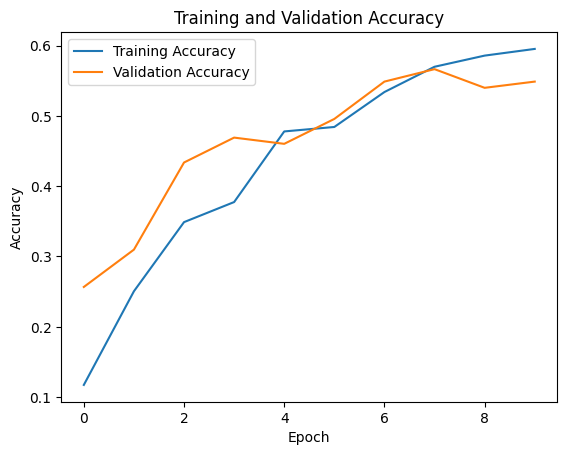

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

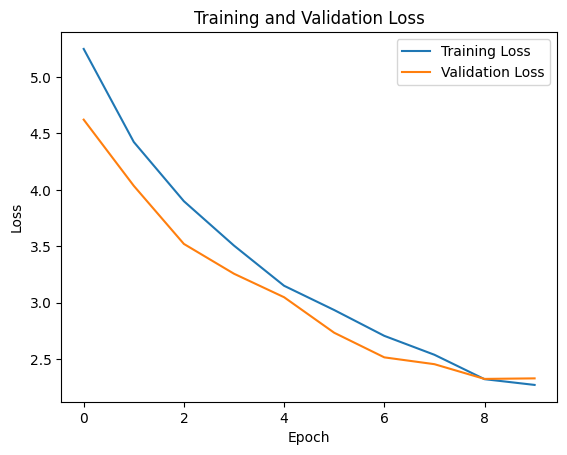

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step


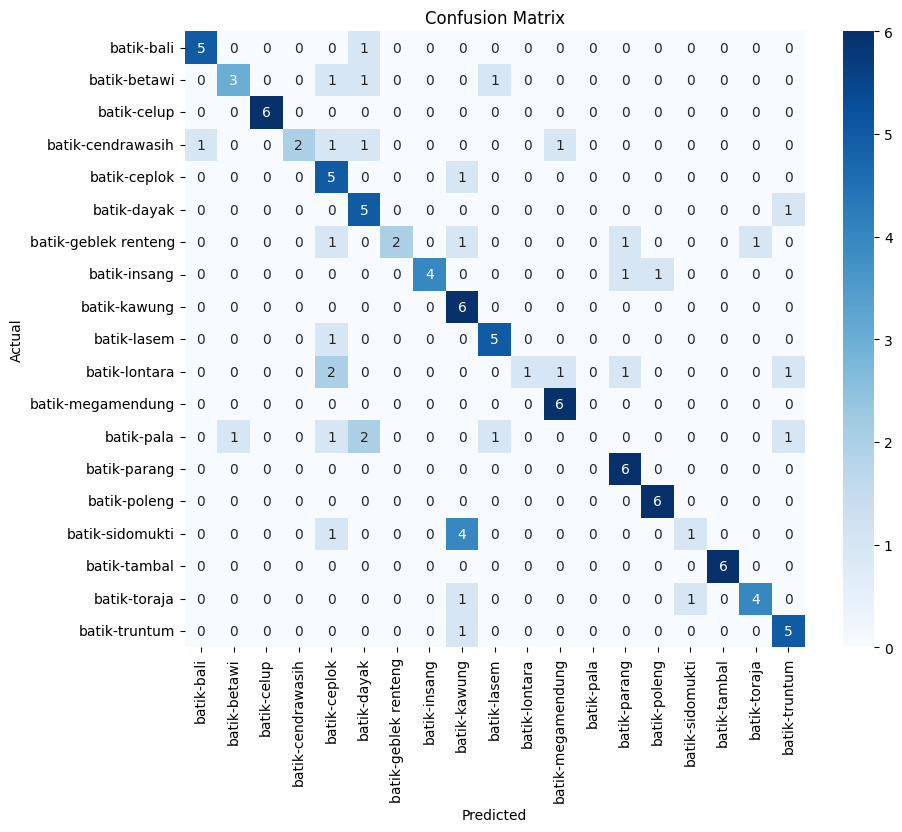

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Mengambil prediksi dari data pengujian
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Membuat Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

# Visualisasi Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Learning rate scheduler function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.1  # Turunkan learning rate setelah 10 epoch

# Callback list with learning rate scheduler
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    LearningRateScheduler(scheduler)
]

# Fine-tuning lebih mendalam dengan epoch lebih banyak
history_fine = model.fit(train_generator,
                         epochs=30,  # Naikkan epoch untuk fine-tuning
                         validation_data=validation_generator,
                         callbacks=callbacks)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy:.2f}')
print(f'Test Loss: {test_loss:.4f}')


Epoch 1/30
 1/15 ━━━━━━━━━━━━━━━━━━━━ 5:11 22s/step - accuracy: 0.7812 - loss: 1.4376

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


15/15 ━━━━━━━━━━━━━━━━━━━━ 93s 5s/step - accuracy: 0.8432 - loss: 1.3141 - val_accuracy: 0.6195 - val_loss: 2.2323 - learning_rate: 2.0000e-05
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 137s 5s/step - accuracy: 0.8178 - loss: 1.4092 - val_accuracy: 0.6195 - val_loss: 2.2372 - learning_rate: 2.0000e-05
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 140s 5s/step - accuracy: 0.8227 - loss: 1.3313 - val_accuracy: 0.6372 - val_loss: 2.2242 - learning_rate: 2.0000e-05
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step - accuracy: 0.8308 - loss: 1.3070 - val_accuracy: 0.6372 - val_loss: 2.2255 - learning_rate: 2.0000e-05
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 88s 5s/step - accuracy: 0.8123 - loss: 1.3324 - val_accuracy: 0.6283 - val_loss: 2.2171 - learning_rate: 2.0000e-05
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 144s 5s/step - accuracy: 0.8448 - loss: 1.3035 - val_accuracy: 0.6283 - val_loss: 2.2048 - learning_rate: 2.0000e-05
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 86s 5s/step - accuracy: 0.8122 - loss: 1.3594

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score, precision_score
import numpy as np

# Prediksi pada data pengujian
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Menghitung Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

# Laporan Klasifikasi (F1-Score, Precision, Recall)
print('Classification Report:')
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()))

# Menghitung F1-Score, Precision, dan Recall secara keseluruhan (macro average)
f1 = f1_score(test_generator.classes, y_pred, average='macro')
recall = recall_score(test_generator.classes, y_pred, average='macro')
precision = precision_score(test_generator.classes, y_pred, average='macro')

print(f'Overall F1-Score: {f1:.2f}')
print(f'Overall Recall: {recall:.2f}')
print(f'Overall Precision: {precision:.2f}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step
Classification Report:
                      precision    recall  f1-score   support

          batik-bali       0.83      0.83      0.83         6
        batik-betawi       0.80      0.67      0.73         6
         batik-celup       0.86      1.00      0.92         6
   batik-cendrawasih       1.00      0.33      0.50         6
        batik-ceplok       0.45      0.83      0.59         6
         batik-dayak       0.60      1.00      0.75         6
batik-geblek renteng       1.00      0.33      0.50         6
        batik-insang       1.00      0.83      0.91         6
        batik-kawung       0.40      1.00      0.57         6
         batik-lasem       0.71      0.83      0.77         6
       batik-lontara       1.00      0.17      0.29         6
   batik-megamendung       0.75      1.00      0.86         6
          batik-pala       1.00      0.17      0.29         6
        batik-parang       0.75      1.00      0.86         6
        ba